This notebook trains both cell line and patient DDPMs with domain alignment introduced between the latent spaces.

Here, there is an additional loss introduced by using the cell line representation as a conditioning parameter (context) during the patient decoding process.

Add drug in input to DDPM - allows more inputs due to combinations between sample, drug. No need to have labels in this stage.

In [1]:
import pandas as pd
import numpy as np

In [2]:
import math

In [3]:
import torch
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader, Dataset

In [4]:
import sys
sys.path.append("../src/tab_ddpm/")

In [5]:
from gaussian_multinomial_diffusion import GaussianMultinomialDiffusion
from modules import MLPDiffusion

In [6]:
sys.path.append("../src/")
from vae_model import vae
from loss_functions import get_kld_loss, coral, compute_covariance, ZINORMLoss
from ffnzinb_model import ffnzinb
from cross_attention import CrossAttention

In [7]:
from itertools import product

In [8]:
device = torch.device("cuda:0")

### Load Datasets

#### Drug Fingerprints

In [9]:
drug_fp = pd.read_csv("/data/ajayago/copied_from_cdal1/ajayago_home_folder/processed/drug_morgan_fingerprints.csv", index_col = 0)
drug_fp

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
drug_name,,,,,,,,,,,,,,,,,,,,,
JW-7-24-1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
KIN001-260,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
NSC-87877,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
GNE-317,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
NAVITOCLAX,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LGH447,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TRASTUZUMAB,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
WNT974,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Cell Lines

In [10]:
cl_train_df = pd.read_csv("../data/diffusion_pretraining/cl_diffusion_train_sample0.csv", index_col=0)
cl_train_df.shape

(1569, 7776)

In [11]:
cl_test_df = pd.read_csv("../data/diffusion_pretraining/cl_diffusion_test_sample0.csv", index_col=0)
cl_test_df.shape

(175, 7776)

In [12]:
cl_train_df.loc["ACH-002277"].values

array([0., 0., 0., ..., 0., 0., 0.])

In [13]:
# for a, b in product(cl_train_df.index, drug_fp.index):
#     with open("/data/ajayago/druid/intermediate/cs6220/train_cl_drug_unlabelled.csv", "a") as f:
#         f.write(f"{a};{b}\n")

In [14]:
# for a, b in product(cl_test_df.index, drug_fp.index):
#     with open("/data/ajayago/druid/intermediate/cs6220/test_cl_drug_unlabelled.csv", "a") as f:
#         f.write(f"{a};{b}\n")

In [15]:
class CustomDataset(Dataset):
    def __init__(self, csv_file, feature_df, drug_df):
        self.inputs = pd.read_csv(csv_file, header=None, sep=";")
        self.inputs.columns = ["patient_id", "drug_name"]
        self.feature_df = feature_df
        self.drug_df = drug_df

    def __getitem__(self, idx):
        patient_id = self.inputs.iloc[idx]["patient_id"]
        drug_name = self.inputs.iloc[idx]["drug_name"]
        return torch.tensor(np.concatenate((self.feature_df.loc[patient_id].values, self.drug_df.loc[drug_name].values)))

    def __len__(self):
        return len(self.inputs)
    

In [16]:
cl_train_dataset = CustomDataset("/data/ajayago/druid/intermediate/cs6220/train_cl_drug_unlabelled.csv", cl_train_df, drug_fp)
cl_test_dataset = CustomDataset("/data/ajayago/druid/intermediate/cs6220/test_cl_drug_unlabelled.csv", cl_test_df, drug_fp)

In [17]:
cl_train_dataloader = DataLoader(cl_train_dataset, batch_size=2056, shuffle=True)
cl_test_dataloader = DataLoader(cl_test_dataset, batch_size=2056, shuffle=False)

#### Patient Dataset

In [18]:
tcga_train_df = pd.read_csv("../data/diffusion_pretraining/tcga_diffusion_train_sample0.csv", index_col=0)
tcga_train_df.shape

(476, 7776)

In [19]:
tcga_test_df = pd.read_csv("../data/diffusion_pretraining/tcga_diffusion_test_sample0.csv", index_col=0)
tcga_test_df.shape

(120, 7776)

In [20]:
# for a, b in product(tcga_train_df.index, drug_fp.index):
#     with open("/data/ajayago/druid/intermediate/cs6220/train_tcga_drug_unlabelled.csv", "a") as f:
#         f.write(f"{a};{b}\n")

In [21]:
# for a, b in product(tcga_test_df.index, drug_fp.index):
#     with open("/data/ajayago/druid/intermediate/cs6220/test_tcga_drug_unlabelled.csv", "a") as f:
#         f.write(f"{a};{b}\n")

In [22]:
tcga_train_dataset = CustomDataset("/data/ajayago/druid/intermediate/cs6220/train_tcga_drug_unlabelled.csv", tcga_train_df, drug_fp)
tcga_test_dataset = CustomDataset("/data/ajayago/druid/intermediate/cs6220/test_tcga_drug_unlabelled.csv", tcga_test_df, drug_fp)

In [23]:
tcga_train_dataloader = DataLoader(tcga_train_dataset, batch_size=2056, shuffle=True)
tcga_test_dataloader = DataLoader(tcga_test_dataset, batch_size=2056, shuffle=False)

In [24]:
len(cl_train_dataset), len(cl_test_dataset), len(tcga_train_dataset), len(tcga_test_dataset)

(640152, 71400, 194208, 48960)

#### Pretrain VAEs separately for cell lines and patients

In [25]:
def testing_loop_vae(test_dataloader, vae, device):
    avg_test_loss = 0.0
    for idx, batch in enumerate(test_dataloader):
        with torch.no_grad():
            inp_vae = batch[0].to(device=device, dtype=torch.float32)
            inp, mu, logvar, inp_dec  = vae(inp_vae) # From VAE encoder + reparameterization

            mse_recon_loss = torch.nn.MSELoss()(inp_dec, inp_vae) # MSE 
            avg_test_loss += mse_recon_loss.detach().item()

    return avg_test_loss/(idx+1)

In [26]:
def training_loop_vae(train_dataloader, test_dataloader, epochs, vae, device, optimizer, scheduler=None):
    train_losses = []
    avg_test_losses = []
    for i in range(epochs):
        loss = 0.0
        avg_test_loss = ""
        for idx, batch in enumerate(train_dataloader):
            optimizer.zero_grad()
            inp_vae = batch.to(device=device, dtype=torch.float32)
            inp, mu, logvar, inp_dec = vae(inp_vae) # From VAE encoder + reparameterization
            # print(mu.shape, logvar.shape)
            mse_recon_loss = torch.nn.MSELoss()(inp_dec, inp_vae) # MSE 
            kld_loss = get_kld_loss(mu, logvar, is_mean=True) # KLD
            total_loss = mse_recon_loss + kld_loss

            total_loss.backward()
            optimizer.step()

            loss += total_loss.detach().item()
            
        test_loss = testing_loop_vae(test_dataloader, vae, device)
        avg_test_loss = f" Average testing loss: {test_loss}"

        print(f"|Epoch {i} | Average training loss: {loss/((idx+1))} |{avg_test_loss}")
        train_losses.append(loss/(idx+1))
        avg_test_losses.append(test_loss)
        
        if scheduler:
            scheduler.step()
        if len(avg_test_losses)> 2:
            if avg_test_losses[-1] > avg_test_losses[-2]:
                print("Converged.")
                break
        
    return train_losses
            

In [27]:
# train cell line VAE
cl_vae = vae(input_dim=7776+2048, k_list=[1024, 128], actf_list=["tanh", "tanh"], is_real=True).to(device)
optim_cl = torch.optim.Adam(cl_vae.parameters(), lr = 1e-4)
cl_vae_train_losses = training_loop_vae(cl_train_dataloader, cl_test_dataloader, 30, cl_vae, device, optim_cl)

U: encoder 
Sequential(
  (enc-0): Linear(in_features=9824, out_features=1024, bias=True)
  (act-0): Tanh()
  (enc-1): Linear(in_features=1024, out_features=128, bias=True)
  (act-1): Tanh()
)
#
mu_layer: 
Linear(in_features=128, out_features=64, bias=True)
#
sigma_layer: 
Linear(in_features=128, out_features=64, bias=True)
#
U: decoder 
Sequential(
  (-dec-0): Linear(in_features=64, out_features=128, bias=True)
  (-act-0): Tanh()
  (dec-0): Linear(in_features=128, out_features=1024, bias=True)
  (act-0): Tanh()
  (dec-1): Linear(in_features=1024, out_features=9824, bias=True)
  (act-1): Tanh()
)
|Epoch 0 | Average training loss: 0.20127451254261863 | Average testing loss: 0.14602950185901303
|Epoch 1 | Average training loss: 0.19869473613870398 | Average testing loss: 0.14601783448798134
|Epoch 2 | Average training loss: 0.19868172175928653 | Average testing loss: 0.1460039440285543
|Epoch 3 | Average training loss: 0.19866322389610624 | Average testing loss: 0.1460033699538259
|Epoch

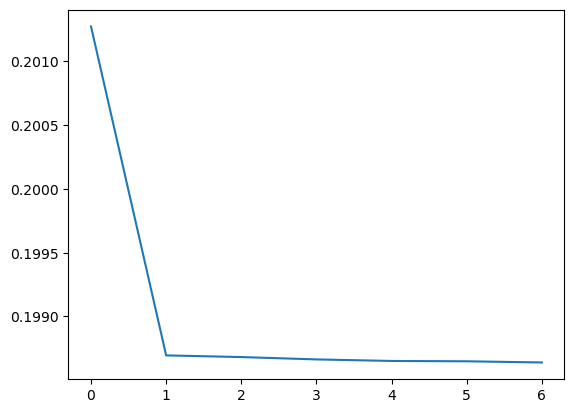

In [28]:
plt.plot(cl_vae_train_losses)

In [29]:
# train patient VAE
patient_vae = vae(input_dim=7776+2048, k_list=[512, 128], actf_list=["tanh", "relu"], is_real=True).to(device)
optim_tcga = torch.optim.Adam(patient_vae.parameters(), lr = 1e-3)
patient_vae_train_losses = training_loop_vae(tcga_train_dataloader, tcga_test_dataloader, 40, patient_vae, device, optim_tcga)

U: encoder 
Sequential(
  (enc-0): Linear(in_features=9824, out_features=512, bias=True)
  (act-0): Tanh()
  (enc-1): Linear(in_features=512, out_features=128, bias=True)
  (act-1): ReLU()
)
#
mu_layer: 
Linear(in_features=128, out_features=64, bias=True)
#
sigma_layer: 
Linear(in_features=128, out_features=64, bias=True)
#
U: decoder 
Sequential(
  (-dec-0): Linear(in_features=64, out_features=128, bias=True)
  (-act-0): Tanh()
  (dec-0): Linear(in_features=128, out_features=512, bias=True)
  (act-0): Tanh()
  (dec-1): Linear(in_features=512, out_features=9824, bias=True)
  (act-1): ReLU()
)
|Epoch 0 | Average training loss: 1.0020566041449412 | Average testing loss: 8.53453230188461
|Epoch 1 | Average training loss: 0.47577153196672556 | Average testing loss: 7.195762190923173
|Epoch 2 | Average training loss: 0.3370311064271544 | Average testing loss: 6.957519980403594
|Epoch 3 | Average training loss: 0.30015764261022937 | Average testing loss: 6.933378139999695
|Epoch 4 | Average 

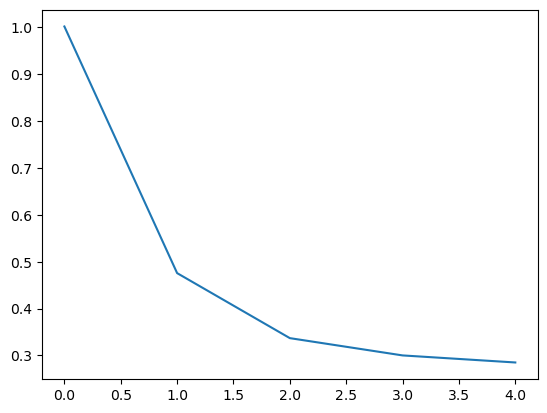

In [30]:
plt.plot(patient_vae_train_losses)

In [48]:
# torch.save(cl_vae.state_dict(), "/data/ajayago/druid/intermediate/cs6220/vae_cell_line_clconditioned_uda_v3_druginput.pth")
# torch.save(patient_vae.state_dict(), "/data/ajayago/druid/intermediate/cs6220/vae_patient_clconditioned_uda_v3_druginput.pth")

#### Joint Training of Cell Line and Patient

Testing is still on patient data. Training involves iterating over cell lines and patients.

We use VAE + TDDPM in each case. Here we also condition the patient decoder on cell line representation (like image generation conditioned on text input.)

In [25]:
# testing function with LDM
def testing_loop_ldm(test_dataloader, diffusion_model, vae, device):
    avg_test_loss = 0.0
    for idx, batch in enumerate(test_dataloader):
        with torch.no_grad():
            inp_vae = batch.to(device=device, dtype=torch.float32)
            inp, mu, logvar, _ = vae(inp_vae) # From VAE encoder + reparameterization
            
            noise = torch.randn_like(inp).to(device) # this is the label we use   
            b = inp.shape[0]
            t, pt = diffusion_model.sample_time(b, device, 'uniform')
            inp_t = diffusion_model.gaussian_q_sample(inp, t, noise) # forward process
            model_out = diffusion_model._denoise_fn(inp_t, t) # predicted epsilon

            # MSE between predicted inp_pred after reverse diffusion and original input
            inp_pred = diffusion_model._predict_xstart_from_eps(inp_t, t, model_out)
            out_vae = vae.decoder(inp_pred) # after VAE decoding
            # X_mu1, X_theta1, X_pi1 = ffn_zinb_model(out_vae) # ZINorm
            mse_recon_loss = torch.nn.MSELoss()(out_vae, inp_vae) # MSE 

            avg_test_loss += mse_recon_loss.detach().item()

    return avg_test_loss/(idx+1)

In [26]:
# training function with LDM with CORAL loss
def training_loop_ldm_coral_conditioning(train_dataloaders, test_dataloaders, epochs, diffusion_model, vae, device, optimizer, scheduler=None):
    train_losses = []
    avg_test_losses = []
    
    for i in range(epochs):
        loss = 0.0
        avg_test_loss = ""
        for idx0, batch0 in enumerate(train_dataloaders["cell_line"]):
            for idx1, batch1 in enumerate(train_dataloaders["patient"]):
                # print(f"CL: {idx0}, patient: {idx1}")
                optimizer.zero_grad()
                # for cell lines
                inp_vae_cl = batch0.to(device=device, dtype=torch.float32)
                inp_cl, mu_cl, logvar_cl, _ = vae["cell_line"](inp_vae_cl) # From VAE encoder + reparameterization
                
                noise_cl = torch.randn_like(inp_cl).to(device) # this is the label we use   
                b = inp_cl.shape[0]
                t, pt = diffusion_model["cell_line"].sample_time(b, device, 'uniform')
                inp_t_cl = diffusion_model["cell_line"].gaussian_q_sample(inp_cl, t, noise_cl) # forward process
                model_out = diffusion_model["cell_line"]._denoise_fn(inp_t_cl, t) # predicted epsilon
                # loss calculation using MSE between predicted and actual noise
                loss_gauss_cl = diffusion_model["cell_line"]._gaussian_loss(model_out, inp_cl, inp_t_cl, t, noise_cl).mean()
    
                # reconstruct inp, pass through VAE decoder and calculate VAE losses
                inp_pred_cl = diffusion_model["cell_line"]._predict_xstart_from_eps(inp_t_cl, t, model_out)
                out_vae_cl = vae["cell_line"].decoder(inp_pred_cl) # after VAE decoding
                mse_recon_loss_cl = torch.nn.MSELoss()(out_vae_cl, inp_vae_cl)
                kld_loss_cl = get_kld_loss(mu_cl, logvar_cl, is_mean=True)

                # for patients
                inp_vae_tcga = batch1.to(device=device, dtype=torch.float32)
                inp_tcga, mu_tcga, logvar_tcga, _ = vae["patient"](inp_vae_tcga) # From VAE encoder + reparameterization
                
                noise_tcga = torch.randn_like(inp_tcga).to(device) # this is the label we use   
                b = inp_tcga.shape[0]
                t, pt = diffusion_model["patient"].sample_time(b, device, 'uniform')
                inp_t_tcga = diffusion_model["patient"].gaussian_q_sample(inp_tcga, t, noise_tcga) # forward process
                
                model_out = diffusion_model["patient"]._denoise_fn(inp_t_tcga, t) # predicted epsilon
                # loss calculation using MSE between predicted and actual noise
                loss_gauss_tcga = diffusion_model["patient"]._gaussian_loss(model_out, inp_tcga, inp_t_tcga, t, noise_tcga).mean()
    
                # reconstruct inp, pass through VAE decoder and calculate VAE losses
                inp_pred_tcga = diffusion_model["patient"]._predict_xstart_from_eps(inp_t_tcga, t, model_out)
                out_vae_tcga = vae["patient"].decoder(inp_pred_tcga) # after VAE decoding
                mse_recon_loss_tcga = torch.nn.MSELoss()(out_vae_tcga, inp_vae_tcga)
                kld_loss_tcga = get_kld_loss(mu_tcga, logvar_tcga, is_mean=True)
                
                # CORAL loss between latent spaces of VAEs - change to latnet space of diffusion models?
                # coral_loss = coral(inp_cl, inp_tcga)
                coral_loss = coral(inp_t_cl, inp_t_tcga)
                
                # cross attention between inp_t_cl from cell line forward process and inp_t_tcga from patient forward process
                # perform cross attention between cell lines and patients in the VAE latent space 
                # forward pass this attention vector through patient DDPM decoder
                # check KL div loss between the patient data original and those with cross attention
                query =  inp_t_tcga
                key = inp_t_cl
                value = inp_t_cl

                cross_attention_tcga = torch.nn.Softmax(dim=1)(query @ key.transpose(0, 1))/math.sqrt(query.shape[1]) @ value # same shape as query
                model_out_cross = diffusion_model["patient"]._denoise_fn(cross_attention_tcga, t) # predicted epsilon
                
                # loss calculation using KL div between predicted and actual noise
                loss_gauss_tcga_cross = diffusion_model["patient"]._vb_terms_bpd(
                                            model_output=model_out_cross,
                                            x_start=inp_tcga,
                                            x_t=inp_t_tcga,
                                            t=t,
                                            clip_denoised=False,
                                            model_kwargs=None,
                                        )["output"].mean()
                #diffusion_model["patient"]._gaussian_loss(model_out, inp_tcga, inp_t_tcga, t, noise_tcga).mean()
                
                total_loss = loss_gauss_cl + loss_gauss_tcga + coral_loss # mse_recon_loss_cl + mse_recon_loss_tcga + kld_loss_cl + kld_loss_tcga + loss_gauss_tcga_cross
                
                total_loss.backward()
                optimizer.step()

                # print(total_loss.detach().item())
                loss += total_loss.detach().item()

        test_loss = testing_loop_ldm(test_dataloaders['patient'], diffusion_model['patient'], vae['patient'], device)
        avg_test_loss = f" Average testing loss: {test_loss}"

        print(f"|Epoch {i} | Average training loss: {loss/((idx0+1) * (idx1+1))} |{avg_test_loss}")
        train_losses.append(loss/((idx0+1) * (idx1+1)))
        avg_test_losses.append(test_loss)
        if len(avg_test_losses) > 2:
            if avg_test_losses[-1] > avg_test_losses[-2]:
                print("Converged")
                break
        
        if scheduler:
            scheduler.step()
        
    return train_losses

In [27]:
train_dataloaders = {
    "cell_line": cl_train_dataloader,
    "patient": tcga_train_dataloader
}

In [28]:
test_dataloaders = {
    "cell_line": cl_test_dataloader,
    "patient": tcga_test_dataloader
}

In [30]:
cl_vae = vae(input_dim=7776+2048, k_list=[1024, 128], actf_list=["tanh", "relu"], is_real=True).to(device)
patient_vae = vae(input_dim=7776+2048, k_list=[512, 128], actf_list=["tanh", "relu"], is_real=True).to(device)
cl_vae.load_state_dict(torch.load("/data/ajayago/druid/intermediate/cs6220/vae_cell_line_clconditioned_uda_v3_druginput.pth"))
patient_vae.load_state_dict(torch.load("/data/ajayago/druid/intermediate/cs6220/vae_patient_clconditioned_uda_v3_druginput.pth"))

U: encoder 
Sequential(
  (enc-0): Linear(in_features=9824, out_features=1024, bias=True)
  (act-0): Tanh()
  (enc-1): Linear(in_features=1024, out_features=128, bias=True)
  (act-1): ReLU()
)
#
mu_layer: 
Linear(in_features=128, out_features=64, bias=True)
#
sigma_layer: 
Linear(in_features=128, out_features=64, bias=True)
#
U: decoder 
Sequential(
  (-dec-0): Linear(in_features=64, out_features=128, bias=True)
  (-act-0): Tanh()
  (dec-0): Linear(in_features=128, out_features=1024, bias=True)
  (act-0): Tanh()
  (dec-1): Linear(in_features=1024, out_features=9824, bias=True)
  (act-1): ReLU()
)
U: encoder 
Sequential(
  (enc-0): Linear(in_features=9824, out_features=512, bias=True)
  (act-0): Tanh()
  (enc-1): Linear(in_features=512, out_features=128, bias=True)
  (act-1): ReLU()
)
#
mu_layer: 
Linear(in_features=128, out_features=64, bias=True)
#
sigma_layer: 
Linear(in_features=128, out_features=64, bias=True)
#
U: decoder 
Sequential(
  (-dec-0): Linear(in_features=64, out_feature

<All keys matched successfully>

In [31]:
# freeze params of VAEs (pretrained)
for param in cl_vae.parameters():
    param.requires_grad = False

for param in patient_vae.parameters():
    param.requires_grad = False

In [32]:
vaes = {
    "cell_line": cl_vae,
    "patient": patient_vae
}

In [33]:
tcga_mlp_diffusion_model = MLPDiffusion(d_in=64, num_classes=0, is_y_cond=False, rtdl_params={"d_layers": [32], "dropout": 0.1}).to(device)
tcga_diff_model = GaussianMultinomialDiffusion(num_classes=np.array([0]), num_numerical_features=64, denoise_fn=tcga_mlp_diffusion_model, device=device)#.to(device)

In [34]:
cl_mlp_diffusion_model = MLPDiffusion(d_in=64, num_classes=0, is_y_cond=False, rtdl_params={"d_layers": [32], "dropout": 0.1}).to(device)
cl_diff_model = GaussianMultinomialDiffusion(num_classes=np.array([0]), num_numerical_features=64, denoise_fn=cl_mlp_diffusion_model, device=device)#.to(device)

In [35]:
diffusion_models = {
    "cell_line": cl_diff_model,
    "patient": tcga_diff_model
}

In [36]:
# params = list(diffusion_models["cell_line"].parameters()) + list(diffusion_models["patient"].parameters()) + list(vaes["cell_line"].parameters()) + list(vaes["patient"].parameters())
params = list(diffusion_models["cell_line"].parameters()) + list(diffusion_models["patient"].parameters())

In [37]:
optim = torch.optim.Adam(params, lr = 1e-4)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, T_max=100)
# scheduler = torch.optim.lr_scheduler.StepLR(optim, 5)

In [38]:
train_losses = training_loop_ldm_coral_conditioning(train_dataloaders, test_dataloaders, 30, diffusion_models, vaes, device, optim)

CL: 244, patient: 73
CL: 244, patient: 74
CL: 244, patient: 75
CL: 244, patient: 76
CL: 244, patient: 77
CL: 244, patient: 78
CL: 244, patient: 79
CL: 244, patient: 80
CL: 244, patient: 81
CL: 244, patient: 82
CL: 244, patient: 83
CL: 244, patient: 84
CL: 244, patient: 85
CL: 244, patient: 86
CL: 244, patient: 87
CL: 244, patient: 88
CL: 244, patient: 89
CL: 244, patient: 90
CL: 244, patient: 91
CL: 244, patient: 92
CL: 244, patient: 93
CL: 244, patient: 94
CL: 245, patient: 0
CL: 245, patient: 1
CL: 245, patient: 2


KeyboardInterrupt: 

In [39]:
plt.plot(train_losses)

NameError: name 'train_losses' is not defined

In [40]:
torch.save(cl_diff_model.state_dict(), "/data/ajayago/druid/intermediate/cs6220/cl_diff_model_clconditioned_uda_v3_druginput.pth")
torch.save(tcga_diff_model.state_dict(), "/data/ajayago/druid/intermediate/cs6220/tcga_diff_model_clconditioned_uda_v3_druginput.pth")

#### Data Augmentation using cell lines

In [30]:
# cl_vae = vae(input_dim=7776, k_list=[1024, 128], actf_list=["tanh", "tanh"], is_real=True)
# tcga_vae = vae(input_dim=7776, k_list=[1024, 128], actf_list=["tanh", "tanh"], is_real=True)

U: encoder 
Sequential(
  (enc-0): Linear(in_features=7776, out_features=1024, bias=True)
  (act-0): Tanh()
  (enc-1): Linear(in_features=1024, out_features=128, bias=True)
  (act-1): Tanh()
)
#
mu_layer: 
Linear(in_features=128, out_features=64, bias=True)
#
sigma_layer: 
Linear(in_features=128, out_features=64, bias=True)
#
U: decoder 
Sequential(
  (-dec-0): Linear(in_features=64, out_features=128, bias=True)
  (-act-0): Tanh()
  (dec-0): Linear(in_features=128, out_features=1024, bias=True)
  (act-0): Tanh()
  (dec-1): Linear(in_features=1024, out_features=7776, bias=True)
  (act-1): Tanh()
)
U: encoder 
Sequential(
  (enc-0): Linear(in_features=7776, out_features=1024, bias=True)
  (act-0): Tanh()
  (enc-1): Linear(in_features=1024, out_features=128, bias=True)
  (act-1): Tanh()
)
#
mu_layer: 
Linear(in_features=128, out_features=64, bias=True)
#
sigma_layer: 
Linear(in_features=128, out_features=64, bias=True)
#
U: decoder 
Sequential(
  (-dec-0): Linear(in_features=64, out_featu

In [31]:
# cl_vae.load_state_dict(torch.load("/data/ajayago/druid/intermediate/cs6220/vae_cell_line_clconditioned.pth"))

<All keys matched successfully>

In [32]:
# tcga_vae.load_state_dict(torch.load("/data/ajayago/druid/intermediate/cs6220/vae_patient_clconditioned.pth"))

<All keys matched successfully>

In [33]:
# cl_mlp_diffusion_model = MLPDiffusion(d_in=64, num_classes=0, is_y_cond=False, rtdl_params={"d_layers": [16], "dropout": 0.1})
# cl_diff_model = GaussianMultinomialDiffusion(num_classes=np.array([0]), num_numerical_features=64, denoise_fn=cl_mlp_diffusion_model)
# cl_diff_model.load_state_dict(torch.load("/data/ajayago/druid/intermediate/cs6220/cl_diff_model_clconditioned.pth"))

<All keys matched successfully>

In [34]:
# tcga_mlp_diffusion_model = MLPDiffusion(d_in=64, num_classes=0, is_y_cond=False, rtdl_params={"d_layers": [16], "dropout": 0.1})
# tcga_diff_model = GaussianMultinomialDiffusion(num_classes=np.array([0]), num_numerical_features=64, denoise_fn=tcga_mlp_diffusion_model)
# tcga_diff_model.load_state_dict(torch.load("/data/ajayago/druid/intermediate/cs6220/tcga_diff_model_clconditioned.pth"))

<All keys matched successfully>

In [41]:
# inference
cl_diff_model.eval()
tcga_diff_model.eval()
cl_vae.eval()
patient_vae.eval()
cl_mlp_diffusion_model.eval()
tcga_mlp_diffusion_model.eval()

MLPDiffusion(
  (mlp): MLP(
    (blocks): ModuleList(
      (0): Block(
        (linear): Linear(in_features=128, out_features=32, bias=True)
        (activation): ReLU()
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (head): Linear(in_features=32, out_features=64, bias=True)
  )
  (proj): Linear(in_features=64, out_features=128, bias=True)
  (time_embed): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): SiLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
  )
)

In [42]:
def augmented_cl(dataloader):
    augmented = []
    for idx, batch in enumerate(dataloader):
        inp_vae = batch.to(device, dtype=torch.float32)
        inp, mu, logvar, _ = cl_vae(inp_vae) # From VAE encoder + reparameterization
        
        noise = torch.randn_like(inp) # this is the label we use   
        b = inp.shape[0]
        # t, pt = diffusion_model["cell_line"].sample_time(b, device, 'uniform')
        t = (torch.ones((b,)) * 700).long().to(device) # fixing time steps to 700
        pt = torch.ones_like(t).float() / cl_diff_model.num_timesteps
        inp_t = cl_diff_model.gaussian_q_sample(inp, t, noise) # forward process with cell line model encoder
        model_out = tcga_diff_model._denoise_fn(inp_t, t) # predicted epsilon from patient decoder
    
        # predict inp from noise using patient model
        inp_pred = tcga_diff_model._predict_xstart_from_eps(inp_t, t, model_out)
        out_vae = patient_vae.decoder(inp_pred) # after VAE decoding with patient decoder
        augmented.append(out_vae)
    return torch.cat(augmented, axis = 0)

In [43]:
augmented_cl_data_test = augmented_cl(cl_test_dataloader)

In [44]:
augmented_cl_data_test.shape

torch.Size([71400, 9824])

In [45]:
augmented_cl_data_train = augmented_cl(cl_train_dataloader)

OutOfMemoryError: CUDA out of memory. Tried to allocate 23.43 GiB. GPU 0 has a total capacity of 44.32 GiB of which 11.13 GiB is free. Including non-PyTorch memory, this process has 33.17 GiB memory in use. Of the allocated memory 32.51 GiB is allocated by PyTorch, and 166.40 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
augmented_cl_data_train.shape

#### Plotting TSNE for the augmented cell line data and actual patient data

In [46]:
from sklearn.manifold import TSNE

In [48]:
tsne = TSNE()

In [49]:
tcga_tsne = tsne.fit_transform(pd.concat([tcga_train_df, tcga_test_df]).values)

In [50]:
# augmented_cell_line = torch.cat((augmented_cl_data_train, augmented_cl_data_test), axis = 0).cpu().detach().numpy()
augmented_cell_line = augmented_cl_data_test.cpu().detach().numpy()
augmented_cell_line.shape

(71400, 9824)

In [ ]:
cl_metadata = pd.read_csv("/data/ajayago/druid/")

In [ ]:
augmented_cell_line_tsne = tsne.fit_transform(augmented_cell_line)

ERROR! Session/line number was not unique in database. History logging moved to new session 253


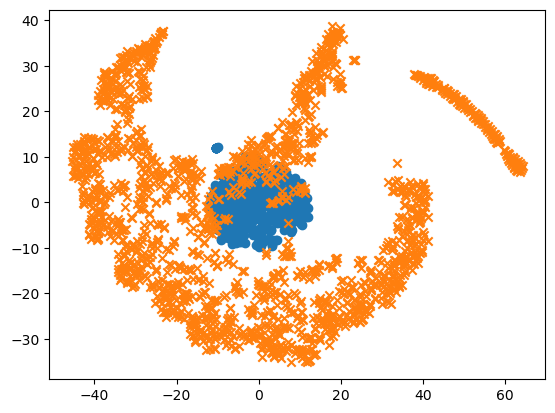

In [61]:
plt.scatter(tcga_tsne[:,0], tcga_tsne[:, 1])
plt.scatter(augmented_cell_line_tsne[:,0], augmented_cell_line_tsne[:, 1], marker="x")

In [48]:
# on original cell line data
augmented_cell_line_tsne_orig = tsne.fit_transform(pd.concat([cl_train_df, cl_test_df]).values)
augmented_cell_line_tsne_orig.shape

(1744, 2)

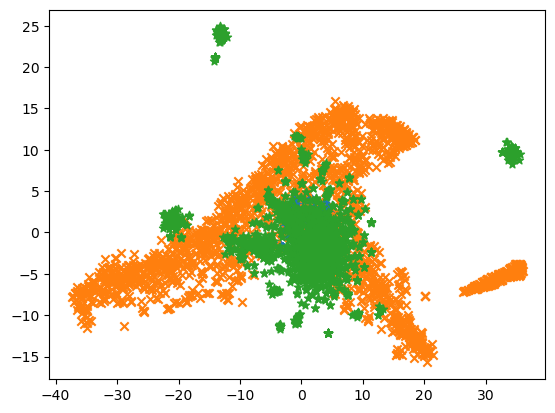

In [49]:
plt.scatter(tcga_tsne[:,0], tcga_tsne[:, 1])
plt.scatter(augmented_cell_line_tsne[:,0], augmented_cell_line_tsne[:, 1], marker="x")
plt.scatter(augmented_cell_line_tsne_orig[:,0], augmented_cell_line_tsne_orig[:, 1], marker="*")

In [70]:
augmented_cl_df = pd.DataFrame(augmented_cell_line, columns = cl_train_df.columns, index=list(cl_train_df.index) + list(cl_test_df.index))
print(augmented_cl_df.shape)
augmented_cl_df.to_csv("/data/ajayago/druid/intermediate/cs6220/augmented_cl_clconditioned_uda_v2.csv")

(1744, 7776)


In [51]:
import umap

/home/ajayago/miniconda3/envs/tddpm/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [52]:
reducer = umap.UMAP(metric="cosine", init="spectral")

In [53]:
tcga_umap = reducer.fit_transform(pd.concat([tcga_train_df, tcga_test_df]).values)

In [54]:
tcga_umap.shape

(596, 2)

In [55]:
augmented_cell_line_umap = reducer.fit_transform(augmented_cell_line)
augmented_cell_line_umap.shape

(1744, 2)

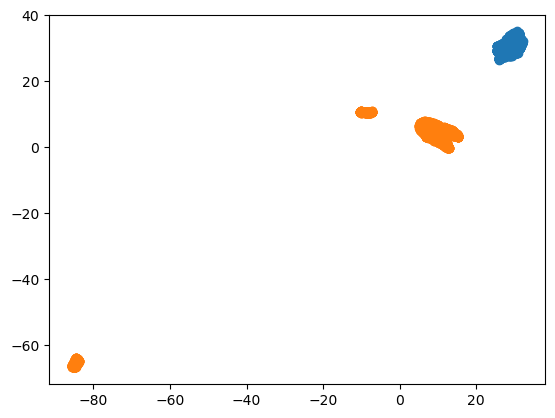

In [56]:
plt.scatter(tcga_umap[:,0], tcga_umap[:, 1])
plt.scatter(augmented_cell_line_umap[:,0], augmented_cell_line_umap[:, 1])